In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D
import time
import copy
from sklearn.cluster import KMeans
import pandas as pd
import gc
from sklearn.linear_model import LinearRegression
import math
import tensorflow as tf
from multiprocessing import Process, Manager
import datetime
import sys
import csv
import os
from tensorflow.keras.utils import to_categorical
from data_generate import *  # 参数生成文件
from KEM_SIMU import *  # KEM 类
sys.path.append('../')
from utils import *

%matplotlib inline

In [2]:
K = 3  # the number of classes
Ch = 0.2293052

lung_image_path = "/database/datasets/Classics/LUNA2016/IMAGES/"  # a folder of CT data
lung_mask_path = "/database/datasets/Classics/LUNA16-Mask/"  # a folder of lung masks
lung_image_file_list = glob(lung_image_path + "*.mhd")  # the absolute paths of the CT files

index = 0 # tour the index th CT data
# a large dict to hold all the necessary information, which will be maily used via Process operations
stats_dict = {'lung_image_path': lung_image_path,
              'lung_mask_path': lung_mask_path,
              'lung_image_file_list': lung_image_file_list,
              }

## CT and Mask Presentation

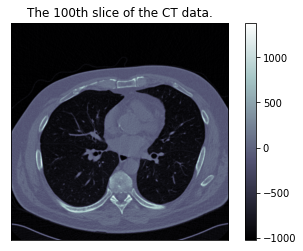

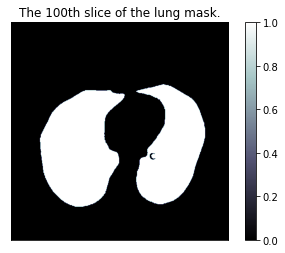

In [3]:
# read in the index th CT data and lung mask
sample_CT_path = stats_dict['lung_image_file_list'][index]
sample_CT_array, lung_mask_array = get_original_data_newversion(stats_dict['lung_image_path'], stats_dict['lung_mask_path'], sample_CT_path)
# show example slices
show_slice(sample_CT_array[99], title="The 100th slice of the CT data.")
show_slice(lung_mask_array[99], title="The 100th slice of the lung mask.")

## Prior Probability and Real Class Presentation

2023-01-18 15:23:32.020151: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 15:23:32.633318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:1c:00.0, compute capability: 6.0
2023-01-18 15:23:33.660523: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


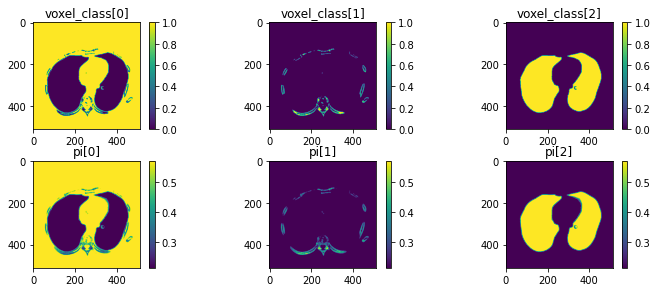

In [4]:
pi, voxel_class = generate_pi_new_version(sample_CT_array, lung_mask_array, bone_threshold=400, IsShow=True)

**🚩Figure 4 of the article**

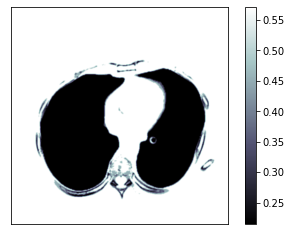

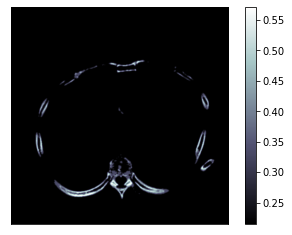

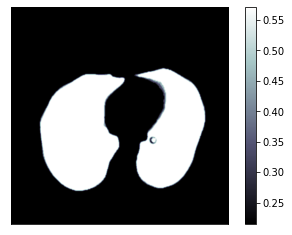

In [5]:
# 论文pi画图
for k in range(3):
    show_slice(pi[k, 99])

## Mean and STD Presentation

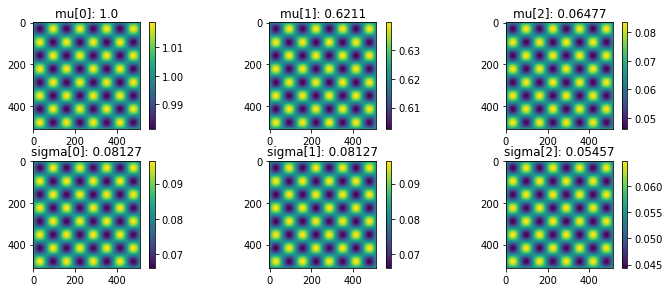

In [6]:
mu, sigma = generate_mu_sigma_new_version(sample_CT_array, voxel_class, IsShow=True)

# Generate the Simulate Data Based on the Parameters

################ k = 0 ################
[0] tmp_data.max: 1.858
[0] tmp_data.mean: 1.0


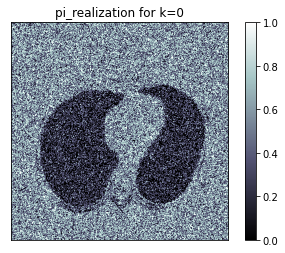

################ k = 1 ################
[1] tmp_data.max: 1.452
[1] tmp_data.mean: 0.6211


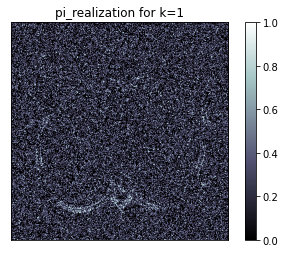

################ k = 2 ################
[2] tmp_data.max: 0.689
[2] tmp_data.mean: 0.06479


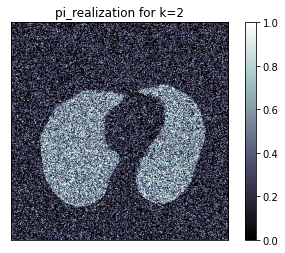

from function(generate_simulate_data_new_version): simulate_data.max=1.785


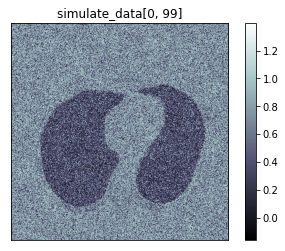

In [7]:
simulate_data, pi_realization = generate_simulate_data_new_version(pi, mu, sigma, seed=0, IsShow=True)

# KEM Algorithm

In [8]:
np.random.seed(0)
tf.random.set_seed(0)

training_ratio = 1  # training_ratio of the voxel positions are used for training
# generate a mask, if =1 then are maintained as training data
position_mask = np.random.binomial(n=1, p=training_ratio, size=simulate_data.shape)
position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
training_data = position_mask * simulate_data

In [9]:
bandwidth, kernel_shape = bandwidth_preparation(sample_CT_array.shape, position_mask, Ch)
print(bandwidth, kernel_shape)

0.018084594009958776 (9, 9, 9)


In [10]:
kem_cv = KEM_SIMU_complex(K=3, 
                          shape=sample_CT_array.shape, 
                          training_data=training_data, 
                          position_mask=position_mask, 
                          kernel_shape=kernel_shape, 
                          bandwidth=bandwidth, 
                          kmeans_sample_ratio=1/100/training_ratio,
                          testing_data=None)

From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.009991 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 1.455 seconds
	centers: [1.0000614  0.6160737  0.06475812]
From function(KEM.__init__): Initialize parameters successfully.
	pik_estimate:(3, 201, 512, 512, 1)
	pi_estimate: (3, 201, 512, 512, 1)
	mu_estimate: (3, 201, 512, 512, 1)
	sigma_estimate: (3, 201, 512, 512, 1)
From function(KEM.__init__): Initialize kernel successfully.
	kernel: (9, 9, 9, 1, 1)


**🚩the original RMSE:**

In [11]:
pi_estimate = tf.squeeze(kem_cv.pi_estimate)
pi_mse = tf.reduce_mean((pi_estimate - pi)**2)
pi_mse = pi_mse.numpy()
pi_rmse = np.sqrt(pi_mse)

mu_estimate = tf.squeeze(kem_cv.mu_estimate)
mu_mse = tf.reduce_mean((mu_estimate - mu)**2)
mu_mse = mu_mse.numpy()
mu_rmse = np.sqrt(mu_mse)

sigma_estimate = tf.squeeze(kem_cv.sigma_estimate)
sigma_mse = tf.reduce_mean((sigma_estimate - sigma)**2)
sigma_mse = sigma_mse.numpy()
sigma_rmse = np.sqrt(sigma_mse)

pi_rmse, mu_rmse, sigma_rmse

(0.16604643, 0.035474, 0.036513705)

**🚩run KEM algorithm:**

In [12]:
kem_cv.kem_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)

From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220945
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0273546
	 Current mu difference: 0.000963891
	 Current sigma difference: 0.00109932
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.0294178.
---This iteration step costs 16.97 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.00116061
From function(kem_algorithm): E step success.
	 Current pi difference: 3.47032e-06
	 Current mu difference: 6.49979e-06
	 Current sigma difference: 1.49126e-05
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 2.48827e-05.
---This iteration step costs 8.186 seconds.---


**🚩re-run the RMSE:**

In [13]:
pi_estimate = tf.squeeze(kem_cv.pi_estimate)
pi_mse = tf.reduce_mean((pi_estimate - pi)**2)
pi_mse = pi_mse.numpy()
pi_rmse = np.sqrt(pi_mse)

mu_estimate = tf.squeeze(kem_cv.mu_estimate)
mu_mse = tf.reduce_mean((mu_estimate - mu)**2)
mu_mse = mu_mse.numpy()
mu_rmse = np.sqrt(mu_mse)

sigma_estimate = tf.squeeze(kem_cv.sigma_estimate)
sigma_mse = tf.reduce_mean((sigma_estimate - sigma)**2)
sigma_mse = sigma_mse.numpy()
sigma_rmse = np.sqrt(sigma_mse)

pi_rmse, mu_rmse, sigma_rmse

(0.026602885, 0.008831105, 0.0063241357)

**🚩graphically show the estimators:**

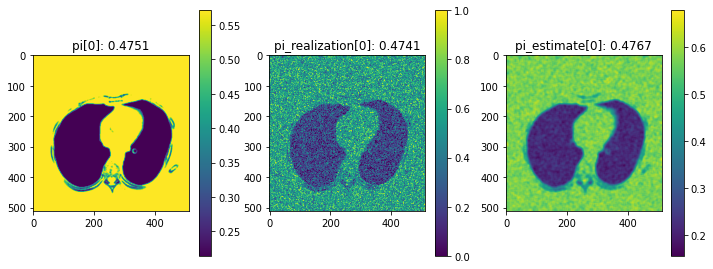

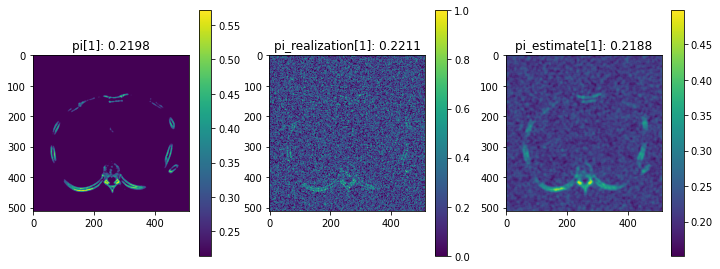

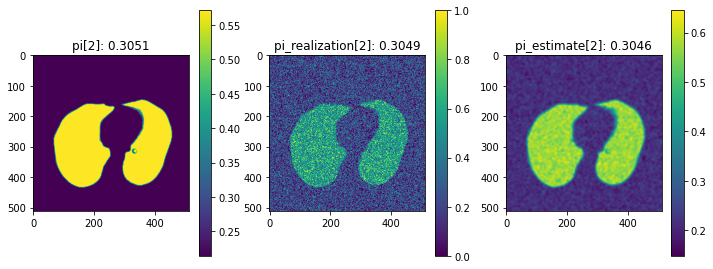

In [15]:
for k in range(3):
    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(10)
    fig.tight_layout()
    # show real prior probability
    ax0 = ax[0].imshow(pi[k, 99])
    ax[0].set_title(f"pi[{k}]: {tf.reduce_mean(pi[k, 99]):.4}")
    fig.colorbar(ax0, ax=ax[0])
    # show pi's realization
    ax1 = ax[1].imshow(pi_realization[k, 99])
    ax[1].set_title(f"pi_realization[{k}]: {tf.reduce_mean(pi_realization[k, 99]):.4}")
    fig.colorbar(ax1, ax=ax[1])
    # show pi estimate
    ax2 = ax[2].imshow(pi_estimate[k, 99])
    ax[2].set_title(f"pi_estimate[{k}]: {tf.reduce_mean(pi_estimate[k, 99]):.4}")
    fig.colorbar(ax2, ax=ax[2])

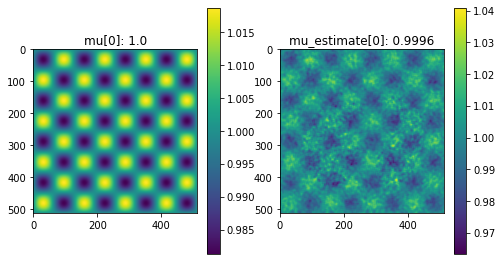

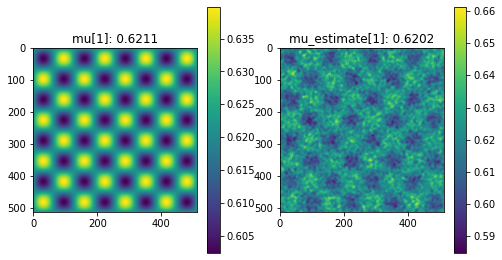

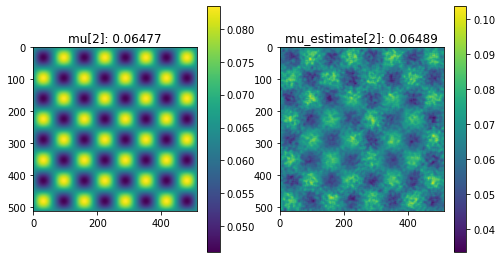

In [22]:
for k in range(3):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(7)
    fig.tight_layout()
    # show real mu
    ax0 = ax[0].imshow(mu[k, 99])
    ax[0].set_title(f"mu[{k}]: {tf.reduce_mean(mu[k, 99]):.4}")
    fig.colorbar(ax0, ax=ax[0])
    # show mu estimate
    ax1 = ax[1].imshow(mu_estimate[k, 99])
    ax[1].set_title(f"mu_estimate[{k}]: {tf.reduce_mean(mu_estimate[k, 99]):.4}")
    fig.colorbar(ax1, ax=ax[1])

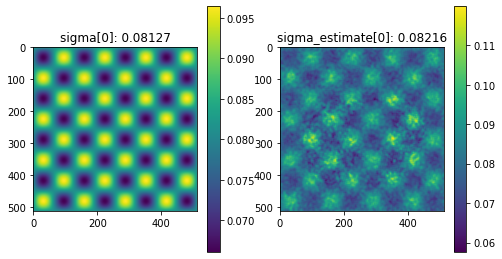

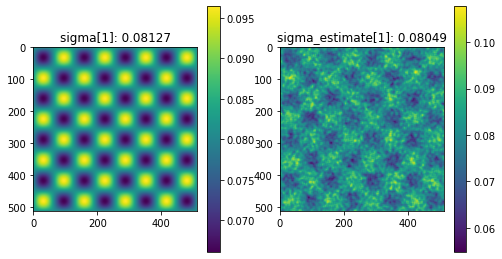

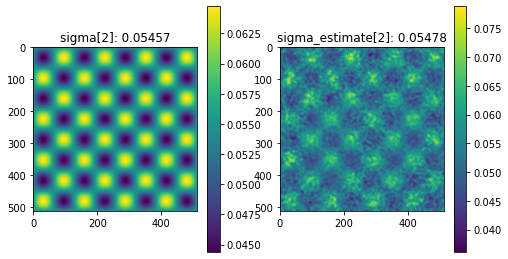

In [23]:
for k in range(3):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(7)
    fig.tight_layout()
    # show real sigma
    ax0 = ax[0].imshow(sigma[k, 99])
    ax[0].set_title(f"sigma[{k}]: {tf.reduce_mean(sigma[k, 99]):.4}")
    fig.colorbar(ax0, ax=ax[0])
    # show sigma estimate
    ax1 = ax[1].imshow(sigma_estimate[k, 99])
    ax[1].set_title(f"sigma_estimate[{k}]: {tf.reduce_mean(sigma_estimate[k, 99]):.4}")
    fig.colorbar(ax1, ax=ax[1])